<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Создание-новых-признаков" data-toc-modified-id="Создание-новых-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание новых признаков</a></span><ul class="toc-item"><li><span><a href="#Выборки" data-toc-modified-id="Выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выборки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений-(регрессия)" data-toc-modified-id="Дерево-решений-(регрессия)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Дерево решений (регрессия)</a></span><ul class="toc-item"><li><span><a href="#кросс-валидация" data-toc-modified-id="кросс-валидация-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>кросс-валидация</a></span></li></ul></li><li><span><a href="#Случайный-лес-(регрессия)" data-toc-modified-id="Случайный-лес-(регрессия)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Случайный лес (регрессия)</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений-регрессия" data-toc-modified-id="Дерево-решений-регрессия-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Дерево решений регрессия</a></span></li><li><span><a href="#Случайный-лес-регрессия" data-toc-modified-id="Случайный-лес-регрессия-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Случайный лес регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Важность-признаков" data-toc-modified-id="Важность-признаков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Важность признаков</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
import lightgbm as lgb
#from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore') 

!pip install optuna
import optuna

Defaulting to user installation because normal site-packages is not writeable


In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(taxi.head())
print(taxi.shape)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


(26496, 1)


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

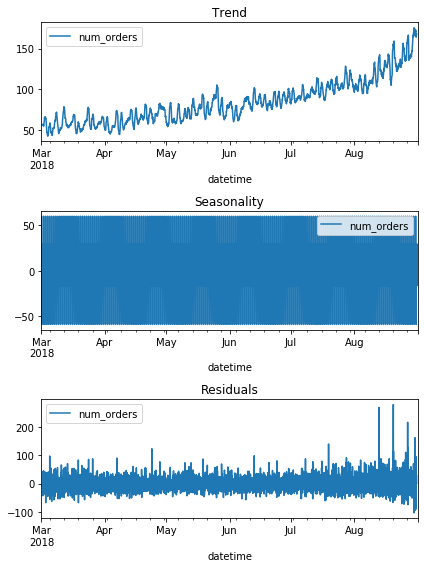

In [6]:
decomposed = seasonal_decompose(taxi) 

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')

plt.tight_layout()


Text(0.5, 1.0, 'Seasonality')

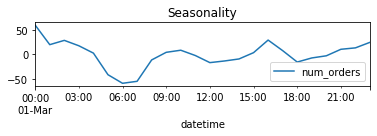

In [7]:
plt.subplot(312)
decomposed.seasonal['2018-03':'2018-03-1'].plot(ax=plt.gca()) 
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

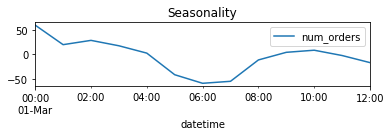

In [8]:
plt.subplot(312)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-01 12:00:00'].plot(ax=plt.gca()) 
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

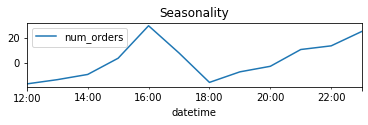

In [9]:
plt.subplot(312)
decomposed.seasonal['2018-03-01 12:00:00':'2018-03-01 23:00:00'].plot(ax=plt.gca()) 
plt.title('Seasonality')

<div class="alert alert-info"> <b> </b> 
    
**Тренд:** ежемесячное увеличение кол-ва заказов.
    
**Сезонность:** снижение заказов к 6 утра, затем резкий подъем к 9 утра, максимальный пик - ближе 00:00.
    
</div>

## Создание новых признаков

In [10]:
df=taxi.copy()
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['dayofyear'] = data.index.dayofyear
    data['hour'] = data.index.hour
    data['week'] = data.index.week
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['lag_1'].rolling(rolling_mean_size).mean()
    #data['rolling_median'] = data['lag_1'].rolling(rolling_mean_size).median()

make_features(df, 12, 6) 
df.head(10)

,num_orders,month,day,dayofweek,dayofyear,hour,week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,60,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,60,1,9,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,60,2,9,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,60,3,9,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,60,4,9,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,60,5,9,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,60,6,9,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,65.833333
2018-03-01 07:00:00,15,3,1,3,60,7,9,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,47.166667
2018-03-01 08:00:00,34,3,1,3,60,8,9,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,35.500000


In [11]:
gr_month=df.groupby('month')['num_orders'].mean().reset_index()
gr_month = gr_month.rename(columns={'num_orders':'month_orders'}) 
gr_month.head()

,month,month_orders
0,3,57.483871
1,4,63.804167
2,5,73.682796
3,6,83.202778
4,7,100.006720


In [12]:
gr_week=df.groupby('week')['num_orders'].mean().reset_index()
gr_week = gr_week.rename(columns={'num_orders':'week_orders'}) 
gr_week

,week,week_orders
0,9,55.218750
1,10,56.017857
2,11,58.244048
3,12,58.136905
4,13,58.047619
5,14,55.815476
6,15,61.619048
7,16,66.809524
8,17,71.672619
9,18,65.166667


In [13]:
df = df.merge(gr_month, on='month', how='left')
df = df.merge(gr_week, on='week', how='left')
print(df.head())


   num_orders  month  day  dayofweek  dayofyear  hour  week  lag_1  lag_2  \
0         124      3    1          3         60     0     9    NaN    NaN   
1          85      3    1          3         60     1     9  124.0    NaN   
2          71      3    1          3         60     2     9   85.0  124.0   
3          66      3    1          3         60     3     9   71.0   85.0   
4          43      3    1          3         60     4     9   66.0   71.0   

   lag_3  ...  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  \
0    NaN  ...    NaN    NaN    NaN    NaN     NaN     NaN     NaN   
1    NaN  ...    NaN    NaN    NaN    NaN     NaN     NaN     NaN   
2    NaN  ...    NaN    NaN    NaN    NaN     NaN     NaN     NaN   
3  124.0  ...    NaN    NaN    NaN    NaN     NaN     NaN     NaN   
4   85.0  ...    NaN    NaN    NaN    NaN     NaN     NaN     NaN   

   rolling_mean  month_orders  week_orders  
0           NaN     57.483871     55.21875  
1           NaN     57.483871   

### Выборки

In [14]:
df=df.dropna()

train_all, test = train_test_split(df, shuffle=False, test_size=0.1)
df.head()

,num_orders,month,day,dayofweek,dayofyear,hour,week,lag_1,lag_2,lag_3,...,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean,month_orders,week_orders
12,30,3,1,3,60,12,9,96.0,64.0,69.0,...,12.0,6.0,43.0,66.0,71.0,85.0,124.0,48.333333,57.483871,55.21875
13,32,3,1,3,60,13,9,30.0,96.0,64.0,...,15.0,12.0,6.0,43.0,66.0,71.0,85.0,51.333333,57.483871,55.21875
14,48,3,1,3,60,14,9,32.0,30.0,96.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,54.166667,57.483871,55.21875
15,66,3,1,3,60,15,9,48.0,32.0,30.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,56.500000,57.483871,55.21875
16,43,3,1,3,60,16,9,66.0,48.0,32.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.000000,57.483871,55.21875


In [15]:
train, valid = train_test_split(train_all, shuffle=False, test_size=0.2)


In [16]:
print(train.shape)
print(valid.shape)
print(test.shape)

(3170, 22)
(793, 22)
(441, 22)


In [17]:
X_train=train.drop('num_orders', axis=1)
y_train=train.num_orders

X_valid=valid.drop('num_orders', axis=1)
y_valid=valid.num_orders

X_test=test.drop('num_orders', axis=1)
y_test=test.num_orders

## Обучение

### Линейная регрессия

In [18]:
%%time
lr_model = LinearRegression()  
lr_model.fit(X_train, y_train) 

predict = lr_model.predict(X_valid) 
result = mean_squared_error(y_valid, predict)**0.5 

print("RMSE модели линейной регрессии на valid-выборке:", result)

RMSE модели линейной регрессии на valid-выборке: 38.08961248002189
CPU times: user 75.1 ms, sys: 52.3 ms, total: 127 ms
Wall time: 79.7 ms


<div class="alert alert-info"> <b> </b> 
  
Самыми важными признаками влияющем на прогноз оказались час и месяц, что соответствует реальности.
         
</div>

### Дерево решений (регрессия)

In [19]:
%%time

best_result=10000

for depth in range(1, 20):
    model =DecisionTreeRegressor(random_state=12345, max_depth=depth) 
    model.fit(X_train, y_train) 

    predictions = model.predict(X_valid) 

    result = mean_squared_error(y_valid, predictions)**0.5 

    if result < best_result:        
        best_result = result
        best_depth = depth
        dtr_model=model
        predict=predictions
           

print("RMSE наилучшей модели (Дерево решений) на valid-выборке:", best_result, "Оптимальная глубина дерева:", best_depth, sep='\n')

RMSE наилучшей модели (Дерево решений) на valid-выборке:
35.13911425470677
Оптимальная глубина дерева:
7
CPU times: user 705 ms, sys: 26.5 ms, total: 732 ms
Wall time: 767 ms


#### кросс-валидация

In [20]:
cross_model =DecisionTreeRegressor(random_state=12345)
tscv = TimeSeriesSplit()
features = train_all.drop(['num_orders'], axis=1)
target = train_all['num_orders']

scores=cross_val_score(cross_model, features, target, cv=tscv, scoring='neg_mean_squared_error') 

final_score=abs(scores.mean())**0.5
print('Средняя оценка качества модели:', final_score)


Средняя оценка качества модели: 36.09707264029388


### Случайный лес (регрессия)

In [21]:
%%time
best_result=10000

for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 

        model.fit(X_train, y_train) 
        predictions = model.predict(X_valid) 
        result = mean_squared_error(y_valid, predictions)**0.5  
        if result < best_result:            
            best_result = result
            best_est = est
            best_depth = depth
            rfr_model=model
            predict=predictions
        
print("RMSE наилучшей модели Случайный лес на valid-выборке:", best_result, "Оптимальное кол-во деревьев:", best_est, "Оптимальная глубина:", best_depth, sep='\n')

RMSE наилучшей модели Случайный лес на valid-выборке:
31.88163934476282
Оптимальное кол-во деревьев:
40
Оптимальная глубина:
10
CPU times: user 22.2 s, sys: 38.7 ms, total: 22.2 s
Wall time: 22.4 s


### CatBoost

In [22]:
%%time
cat_model = CatBoostRegressor(iterations=300, random_state=12345, depth=10) 

cat_model.fit(X_train, y_train, verbose=10) 
predictions = cat_model.predict(X_valid) 

rmse = mean_squared_error(y_valid, predictions)**0.5

print("RMSE модели CatBoost на valid-выборке:", rmse)

0:	learn: 33.7286166	total: 73.9ms	remaining: 22.1s
10:	learn: 29.6415987	total: 1.06s	remaining: 27.9s
20:	learn: 26.7527845	total: 2.06s	remaining: 27.3s
30:	learn: 24.6443363	total: 3.05s	remaining: 26.5s
40:	learn: 23.0847104	total: 4.04s	remaining: 25.5s
50:	learn: 21.8241380	total: 5.04s	remaining: 24.6s
60:	learn: 20.7976041	total: 6.03s	remaining: 23.6s
70:	learn: 19.9967472	total: 7.03s	remaining: 22.7s
80:	learn: 19.2971756	total: 7.94s	remaining: 21.5s
90:	learn: 18.7426448	total: 8.93s	remaining: 20.5s
100:	learn: 18.2641232	total: 10s	remaining: 19.7s
110:	learn: 17.8103668	total: 11.1s	remaining: 18.9s
120:	learn: 17.4141697	total: 12s	remaining: 17.8s
130:	learn: 17.1002033	total: 13s	remaining: 16.8s
140:	learn: 16.7825095	total: 14s	remaining: 15.8s
150:	learn: 16.4871895	total: 15s	remaining: 14.8s
160:	learn: 16.1852920	total: 16s	remaining: 13.8s
170:	learn: 15.9102734	total: 17s	remaining: 12.8s
180:	learn: 15.6341712	total: 18s	remaining: 11.8s
190:	learn: 15.3775

### LightGBM

In [23]:
%%time

def lgbm_reg(trial):        
    
    params={'verbosity':-1,
    'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 1), 
    'max_depth': trial.suggest_int('max_depth', 5, 100, step=0.05),
    'num_leaves': trial.suggest_int('num_leaves', 5, 105, step=10),
    'Learning_rate' : trial.suggest_float('learning_rate',0.001, 0.1, step=0.01),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)        
           }
        
    reg = lgb.LGBMRegressor(**params, random_state=12345)                           

    reg.fit(X_train, y_train) 

    y_pr = reg.predict(X_valid)

    rmse = mean_squared_error(y_valid, y_pr)**0.5  
            
    return rmse

study = optuna.create_study()
study.optimize(lgbm_reg, n_trials=10)

[I 2022-01-27 10:28:19,307] A new study created in memory with name: no-name-d819b37f-2e94-437f-b136-9ab8e04e2cc8
[I 2022-01-27 10:28:20,170] Trial 0 finished with value: 29.957776336265134 and parameters: {'lambda_l2': 0.43379837545166944, 'max_depth': 63, 'num_leaves': 15, 'learning_rate': 0.011, 'bagging_fraction': 0.7}. Best is trial 0 with value: 29.957776336265134.
[I 2022-01-27 10:28:23,774] Trial 1 finished with value: 29.688875427324533 and parameters: {'lambda_l2': 0.6601078599131901, 'max_depth': 13, 'num_leaves': 105, 'learning_rate': 0.021, 'bagging_fraction': 0.8}. Best is trial 1 with value: 29.688875427324533.
[I 2022-01-27 10:28:25,972] Trial 2 finished with value: 30.340084805177476 and parameters: {'lambda_l2': 0.20322443800173717, 'max_depth': 7, 'num_leaves': 95, 'learning_rate': 0.07100000000000001, 'bagging_fraction': 0.7}. Best is trial 1 with value: 29.688875427324533.
[I 2022-01-27 10:28:30,860] Trial 3 finished with value: 29.861268574152927 and parameters: {

CPU times: user 25.8 s, sys: 457 ms, total: 26.2 s
Wall time: 26.6 s


In [24]:
study.best_params

{'lambda_l2': 0.6446587826318175,
 'max_depth': 48,
 'num_leaves': 45,
 'learning_rate': 0.051000000000000004,
 'bagging_fraction': 0.7}

In [25]:
#записываем модель с лучшими параметрами
light_model=lgb.LGBMRegressor(**study.best_params)
light_model

LGBMRegressor(bagging_fraction=0.7, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split',
              lambda_l2=0.6446587826318175, learning_rate=0.051000000000000004,
              max_depth=48, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=45,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [26]:
light_model.fit(X_train, y_train)
predictions = light_model.predict(X_valid)

In [27]:
rmse = mean_squared_error(y_valid, predictions)**0.5
rmse
print("RMSE модели LightGBM на valid-выборке:", rmse)

RMSE модели LightGBM на valid-выборке: 30.022254717394546


## Тестирование

In [28]:
#train_all= train + valid
X_valid=train_all.drop('num_orders', axis=1)
y_valid=train_all.num_orders

### Линейная регрессия

In [29]:
lr_model.fit(X_valid, y_valid)
lr_predict = lr_model.predict(X_test) 
result = mean_squared_error(y_test, lr_predict)**0.5 

print("RMSE:", result)

RMSE: 49.54523225926798


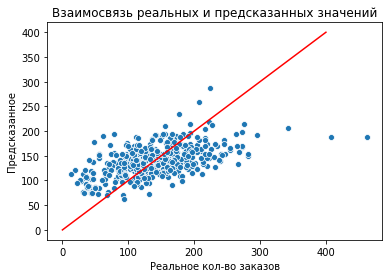

In [30]:
plot = sns.scatterplot(y_test, lr_predict)

plot.set(xlabel='Реальное кол-во заказов', ylabel='Предсказанное')
plt.title('Взаимосвязь реальных и предсказанных значений')
x_plot = np.linspace(0,400,400)
y_plot = x_plot
plt.plot(x_plot, y_plot, color='r')
plt.show()

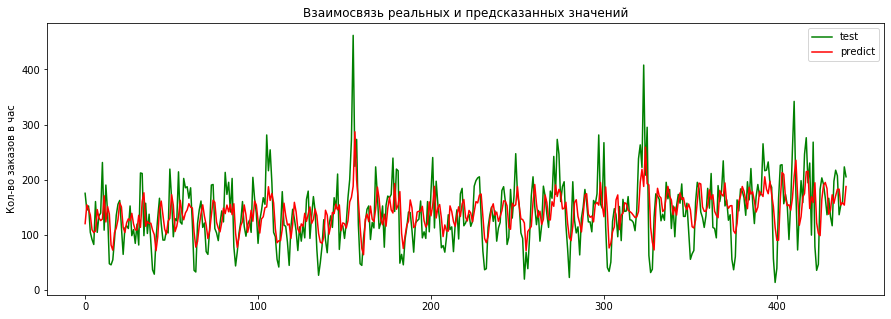

In [31]:
pfig,axes = plt.subplots(figsize= (15,5))
plt.title('Взаимосвязь реальных и предсказанных значений')
x = list(y_test.reset_index(drop=True).index)
y = np.array(y_test)
y2 = lr_predict

plt.plot(x,y, color='green', label='test')
plt.plot(x,y2, color='red', label='predict')
plt.ylabel("Кол-во заказов в час")
plt.legend();
plt.show()

### Дерево решений регрессия

In [32]:
dtr_model.fit(X_valid, y_valid)
dtr_predict = dtr_model.predict(X_test) 
result = mean_squared_error(y_test, dtr_predict)**0.5 

print("RMSE:", result)

RMSE: 53.29903267222459


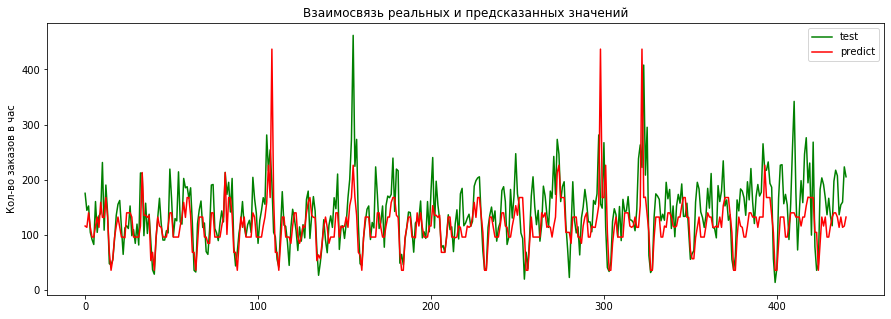

In [33]:
pfig,axes = plt.subplots(figsize= (15,5))
plt.title('Взаимосвязь реальных и предсказанных значений')
#x = list(y_test.reset_index(drop=True).index)
#y = np.array(y_test)
y2 = dtr_predict

plt.plot(x,y, color='green', label='test')
plt.plot(x,y2, color='red', label='predict')
plt.ylabel("Кол-во заказов в час")
plt.legend();
plt.show()

In [34]:
cross_model.fit(X_train, y_train)
cross_predict = cross_model.predict(X_test) 
result = mean_squared_error(y_test, cross_predict)**0.5 

print("RMSE:", result)

RMSE: 68.32151880610375


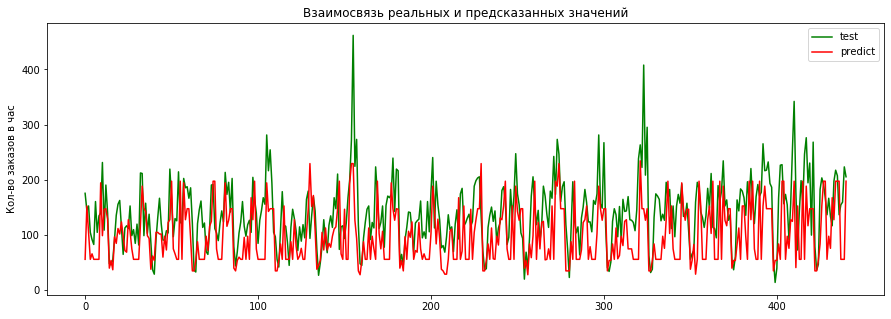

In [35]:
pfig,axes = plt.subplots(figsize= (15,5))
plt.title('Взаимосвязь реальных и предсказанных значений')
#x = list(y_test.reset_index(drop=True).index)
#y = np.array(y_test)
y2 = cross_predict

plt.plot(x,y, color='green', label='test')
plt.plot(x,y2, color='red', label='predict')
plt.ylabel("Кол-во заказов в час")
plt.legend();
plt.show()

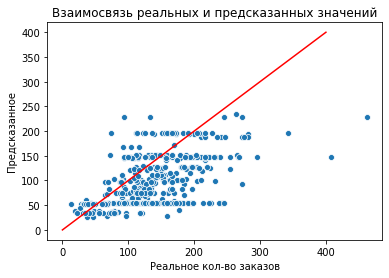

In [36]:
plot = sns.scatterplot(y_test, cross_predict)

plot.set(xlabel='Реальное кол-во заказов', ylabel='Предсказанное')
plt.title('Взаимосвязь реальных и предсказанных значений')
x_plot = np.linspace(0,400,400)
y_plot = x_plot
plt.plot(x_plot, y_plot, color='r')
plt.show()

### Случайный лес регрессия

In [37]:
rfr_model.fit(X_valid, y_valid)
rfr_predict = rfr_model.predict(X_test) 
result = mean_squared_error(y_test, rfr_predict)**0.5 

print("RMSE:", result)

RMSE: 43.818675354042234


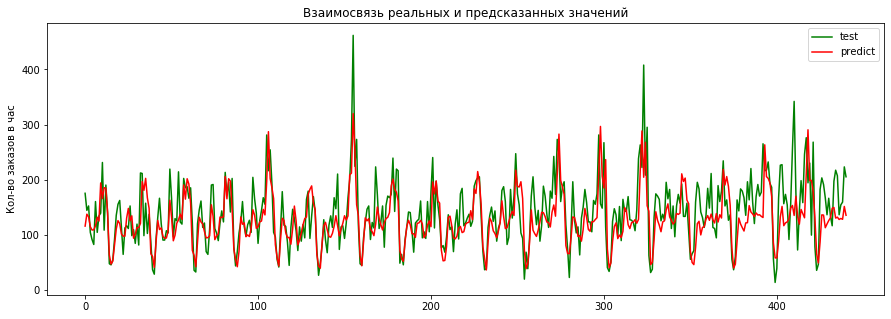

In [38]:
pfig,axes = plt.subplots(figsize= (15,5))
plt.title('Взаимосвязь реальных и предсказанных значений')
#x = list(y_test.reset_index(drop=True).index)
#y = np.array(y_test)
y2 = rfr_predict

plt.plot(x,y, color='green', label='test')
plt.plot(x,y2, color='red', label='predict')
plt.ylabel("Кол-во заказов в час")
plt.legend();
plt.show()

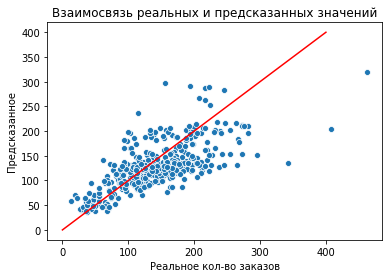

In [39]:
plot = sns.scatterplot(y_test, rfr_predict)

plot.set(xlabel='Реальное кол-во заказов', ylabel='Предсказанное')
plt.title('Взаимосвязь реальных и предсказанных значений')
x_plot = np.linspace(0,400,400)
y_plot = x_plot
plt.plot(x_plot, y_plot, color='r')
plt.show()

### CatBoost

In [40]:
cat_model.fit(X_valid, y_valid)
cat_predict = cat_model.predict(X_test) 
result = mean_squared_error(y_test, cat_predict)**0.5 

print("RMSE:", result)

0:	learn: 38.1040843	total: 90.8ms	remaining: 27.2s
1:	learn: 37.5509384	total: 195ms	remaining: 29s
2:	learn: 36.9877201	total: 296ms	remaining: 29.3s
3:	learn: 36.4653819	total: 403ms	remaining: 29.8s
4:	learn: 35.9949810	total: 582ms	remaining: 34.3s
5:	learn: 35.4753356	total: 682ms	remaining: 33.4s
6:	learn: 34.9790367	total: 781ms	remaining: 32.7s
7:	learn: 34.5185467	total: 881ms	remaining: 32.2s
8:	learn: 34.0826243	total: 982ms	remaining: 31.8s
9:	learn: 33.6490008	total: 1.08s	remaining: 31.4s
10:	learn: 33.2257435	total: 1.18s	remaining: 31.1s
11:	learn: 32.8565337	total: 1.29s	remaining: 30.9s
12:	learn: 32.5235963	total: 1.39s	remaining: 30.7s
13:	learn: 32.1514096	total: 1.57s	remaining: 32.2s
14:	learn: 31.7686843	total: 1.68s	remaining: 31.8s
15:	learn: 31.4451323	total: 1.78s	remaining: 31.6s
16:	learn: 31.1182491	total: 1.88s	remaining: 31.3s
17:	learn: 30.8035926	total: 1.98s	remaining: 31s
18:	learn: 30.4719535	total: 2.08s	remaining: 30.8s
19:	learn: 30.1648375	tot

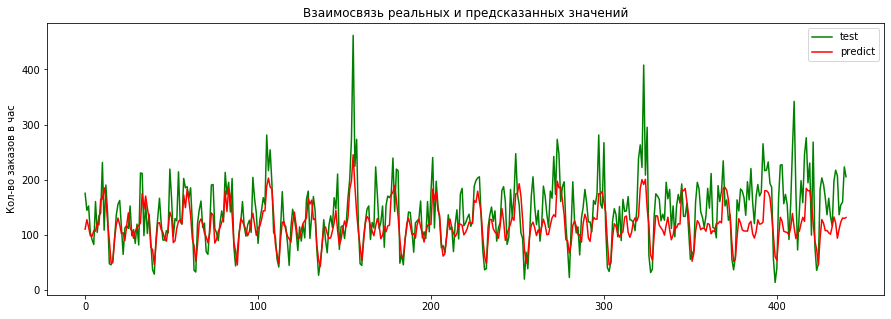

In [41]:
pfig,axes = plt.subplots(figsize= (15,5))
plt.title('Взаимосвязь реальных и предсказанных значений')
#x = list(y_test.reset_index(drop=True).index)
#y = np.array(y_test)
y2 = cat_predict

plt.plot(x,y, color='green', label='test')
plt.plot(x,y2, color='red', label='predict')
plt.ylabel("Кол-во заказов в час")
plt.legend();
plt.show()

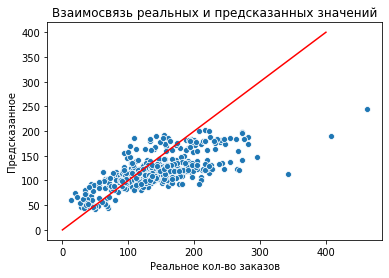

In [42]:
plot = sns.scatterplot(y_test, cat_predict)

plot.set(xlabel='Реальное кол-во заказов', ylabel='Предсказанное')
plt.title('Взаимосвязь реальных и предсказанных значений')
x_plot = np.linspace(0,400,400)
y_plot = x_plot
plt.plot(x_plot, y_plot, color='r')
plt.show()

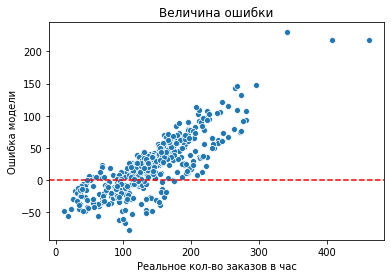

In [43]:
plot = sns.scatterplot(y_test, y_test-cat_predict)
plot.set(xlabel='Реальное кол-во заказов в час', ylabel='Ошибка модели')
plt.title('Величина ошибки')
plt.axhline(y=0, color='red', linestyle='--') 
plt.show()

### LightGBM

In [44]:
light_model.fit(X_valid, y_valid)
light_predict = light_model.predict(X_test) 
result = mean_squared_error(y_test, light_predict)**0.5 

print("RMSE:", result)

RMSE: 42.39261136515477


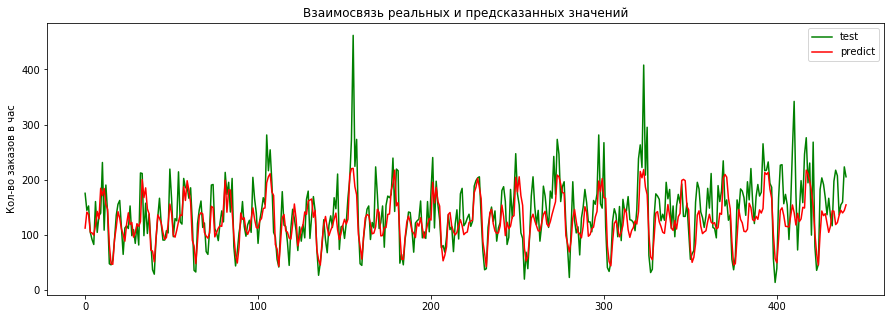

In [45]:
pfig,axes = plt.subplots(figsize= (15,5))
plt.title('Взаимосвязь реальных и предсказанных значений')
#x = list(y_test.reset_index(drop=True).index)
#y = np.array(y_test)
y2 = light_predict

plt.plot(x,y, color='green', label='test')
plt.plot(x,y2, color='red', label='predict')
plt.ylabel("Кол-во заказов в час")
plt.legend();
plt.show()

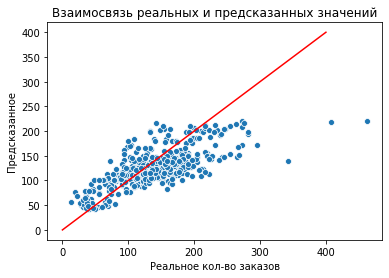

In [46]:
plot = sns.scatterplot(y_test, light_predict)

plot.set(xlabel='Реальное кол-во заказов', ylabel='Предсказанное')
plt.title('Взаимосвязь реальных и предсказанных значений')
x_plot = np.linspace(0,400,400)
y_plot = x_plot
plt.plot(x_plot, y_plot, color='r')
plt.show()

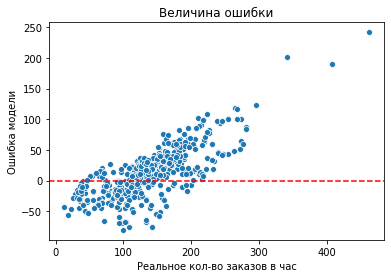

In [47]:
plot = sns.scatterplot(y_test, y_test-light_predict)
plot.set(xlabel='Реальное кол-во заказов в час', ylabel='Ошибка модели')
plt.title('Величина ошибки')
plt.axhline(y=0, color='red', linestyle='--') 
plt.show()

<div class="alert alert-info"> <b> </b> 
    
**Качество моделей на тестовой выборке**
    
LightGBM: rmse - 42.   
    
CatBoost: rmse - 47.
    
Линейная регрессия: rmse - 49.
    
Дерево решений: rmse - 53.
    
Случайный лес: rmse - 43.   
    
    
**Оптимальная модель** - Случайный лес и LightGBM, rmse 43 и 42 соответственно.  
    
</div>

## Важность признаков

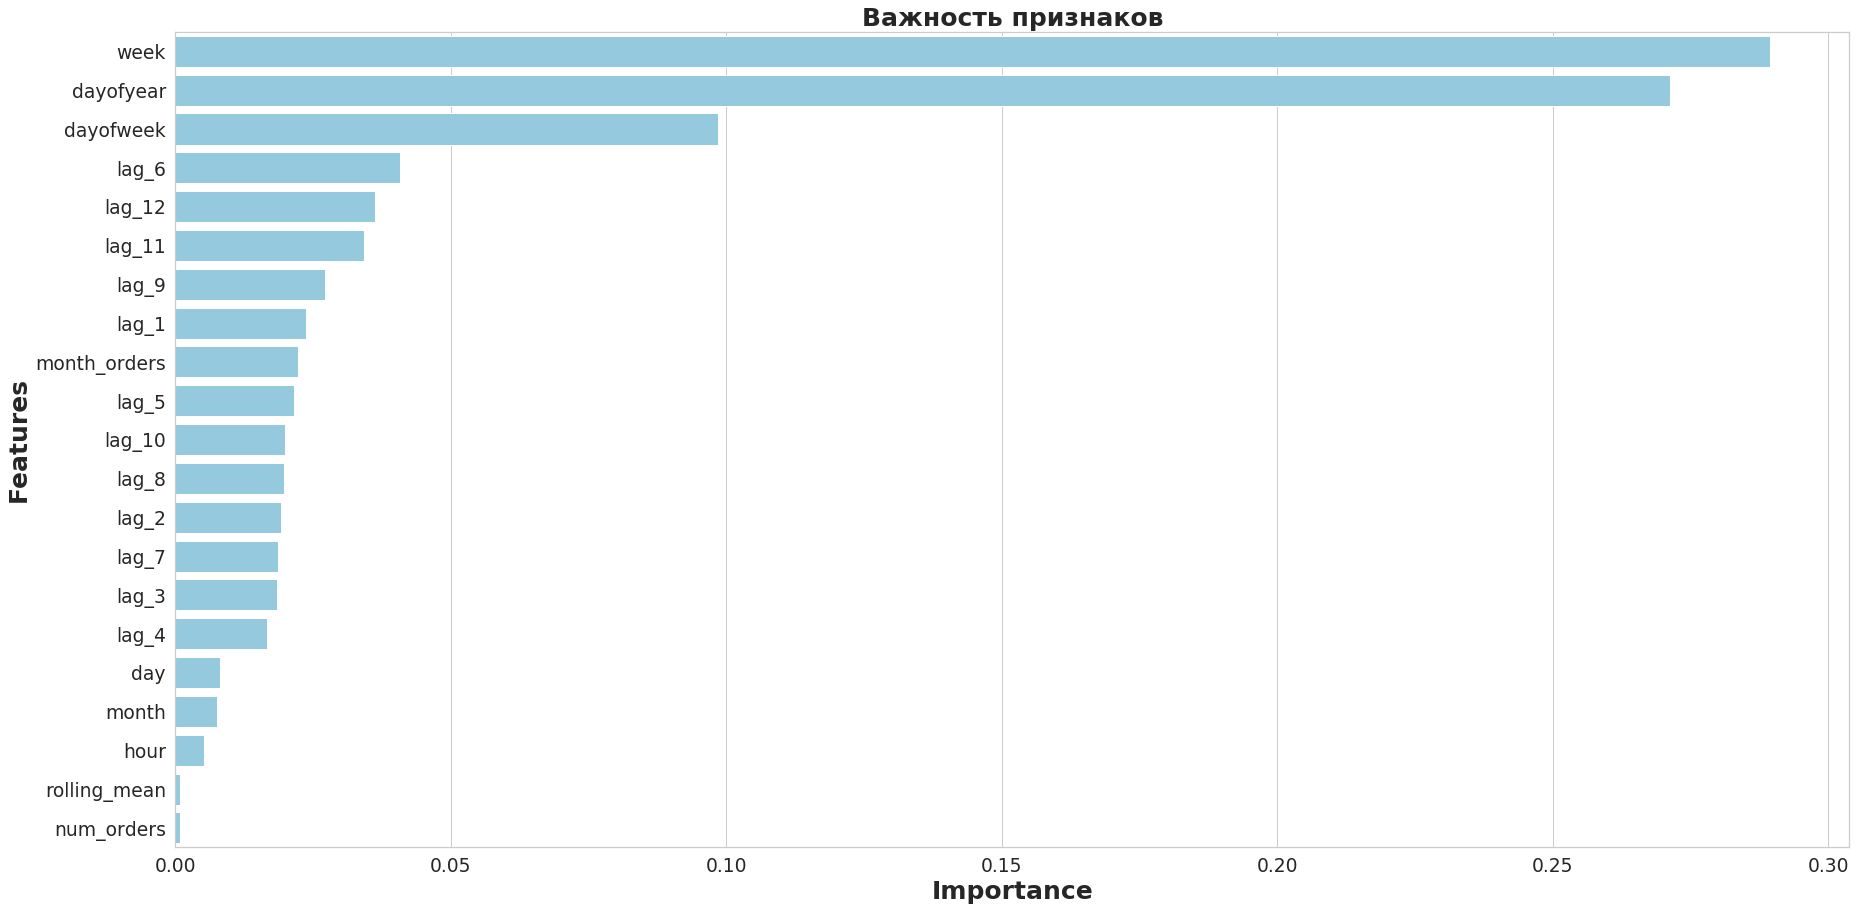

None

,Features,Gini-Importance
0,week,0.289355
1,dayofyear,0.271260
2,dayofweek,0.098415
3,lag_6,0.040693
4,lag_12,0.036139
5,lag_11,0.034256
6,lag_9,0.027167
7,lag_1,0.023748
8,month_orders,0.022303
9,lag_5,0.021598


In [48]:
feats = {}
for feature, importance in zip(df.columns, rfr_model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Важность признаков', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)